# `FaradayModel` Tutorial

Trey V. Wenger (c) February 2025

Here we demonstrate the basic features of the `FaradayModel` model. The `FaradayModel` predicts Stokes Q, U, and Faraday depth spectra by decomposing the Faraday depth spectrum into a series of Gaussian "clouds". Please review the `bayes_spec` documentation and tutorials for a more thorough description of the steps outlined in this tutorial: https://bayes-spec.readthedocs.io/en/stable/index.html

In [2]:
# General imports    
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_pol
print("bayes_pol version:", bayes_pol.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.20.0
bayes_spec version: 1.7.2+4.gfef408d
bayes_pol version: 0+untagged.1.gabd3ba0.dirty


## Simulating Data

To test the model, we must simulate some data. We can do this with `FaradayModel`, but we must pack a "dummy" data structure first.

Faraday depth noise:  0.04805693313322127


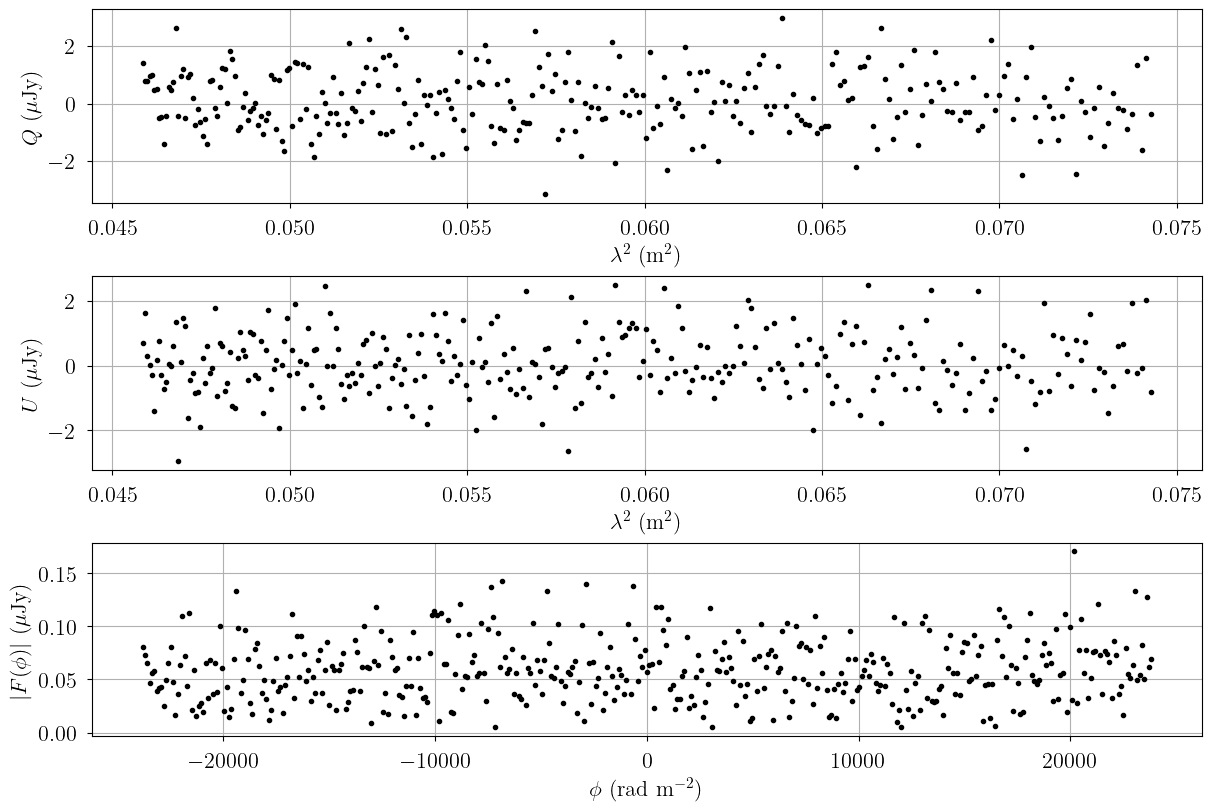

In [30]:
from bayes_spec import SpecData

# spectral axis definition
freq_axis = np.linspace(1.1e9, 1.4e9, 300) # Hz
lam2_axis = (2.99792458e+08/freq_axis[::-1])**2.0 # m2

# Uniform lam2 axis for Fourier transform
lam2_chan = np.diff(lam2_axis).min()
lam2_regular_axis = np.arange(lam2_axis.min(), lam2_axis.max()+lam2_chan, lam2_chan)
lam2_window_width = np.ptp(lam2_axis)

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
rms = 1.0 # uJy

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
stokesQ = rms * np.random.randn(len(lam2_axis)) # uJy
stokesU = rms * np.random.randn(len(lam2_axis)) # uJy

# Faraday depth spectral axis, wraps at pi (rad/m2)
faraday_depth_axis = np.fft.fftshift(np.fft.fftfreq(len(lam2_regular_axis), d=lam2_chan/np.pi))

# Faraday depth spectrum (uJy)
stokesQ_interp = rms * np.random.randn(len(lam2_regular_axis)) # uJy
stokesU_interp = rms * np.random.randn(len(lam2_regular_axis)) # uJy
complex_pol = stokesQ_interp + 1.0j*stokesU_interp
faraday_depth = np.fft.fftshift(np.fft.fft(complex_pol, norm="backward"))/len(lam2_regular_axis)

obs_Q = SpecData(
    lam2_axis,
    stokesQ,
    rms * np.ones_like(stokesQ),
    xlabel=r"$\lambda^2$ (m$^2$)",
    ylabel=r"$Q$ ($\mu$Jy)",
)
obs_U = SpecData(
    lam2_axis,
    stokesU,
    rms * np.ones_like(stokesU),
    xlabel=r"$\lambda^2$ (m$^2$)",
    ylabel=r"$U$ ($\mu$Jy)",
)
obs_faraday_depth_abs = SpecData(
    faraday_depth_axis,
    np.abs(faraday_depth),
    rms / np.sqrt(len(lam2_regular_axis)),
    xlabel=r"$\phi$ (rad m$^{-2}$)",
    ylabel=r"$|F(\phi)|$ ($\mu$Jy)",
)
print("Faraday depth noise: ", obs_faraday_depth_abs.noise[0])
dummy_data = {
    "Q": obs_Q,
    "U": obs_U,
    "faraday_depth_abs": obs_faraday_depth_abs,
}

# Plot the simulated data
fig, axes = plt.subplots(len(dummy_data), figsize=(12, 8), layout="constrained", squeeze=False)
for ax, dataset in zip(axes.ravel(), dummy_data.values()):
    ax.plot(dataset.spectral, dataset.brightness, "k.")
    ax.set_xlabel(dataset.xlabel)
    ax.set_ylabel(dataset.ylabel)

Now that we have a dummy data format, we can generate a simulated observation by evaluating the model for a given set of parameters.

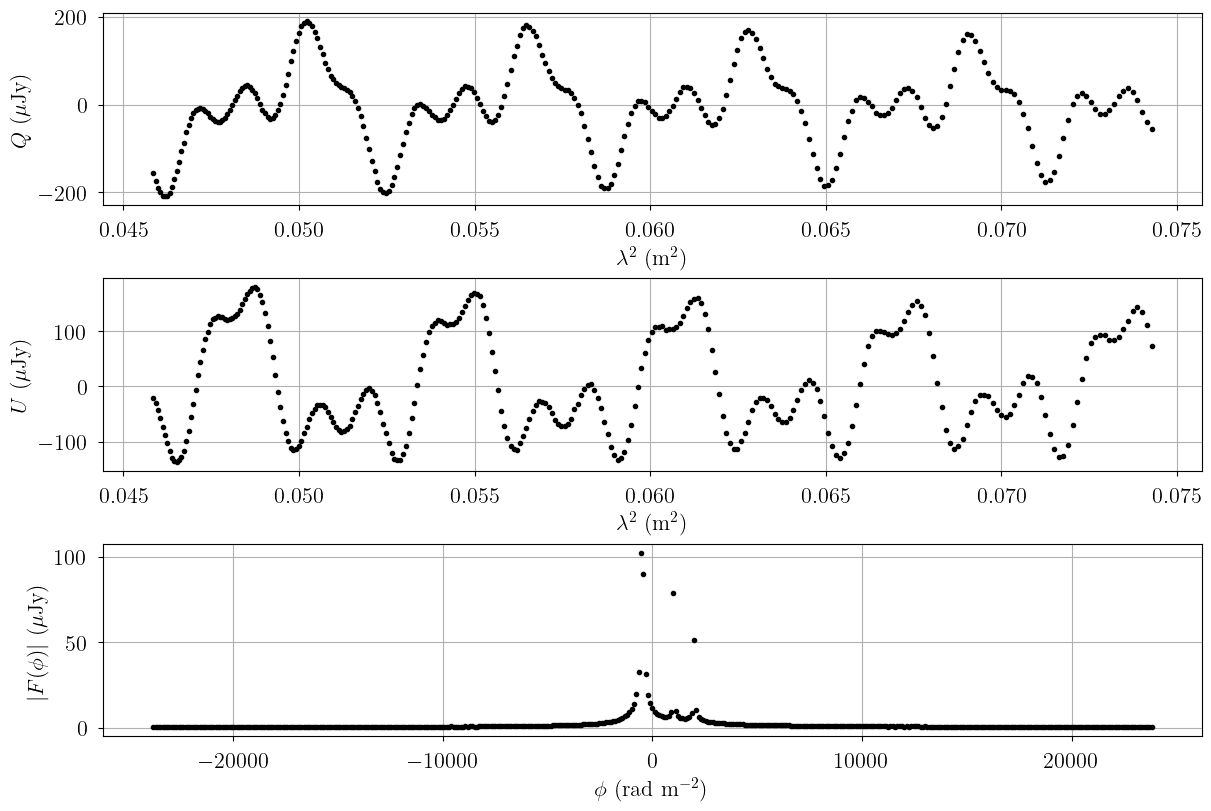

In [31]:
from bayes_pol import FaradayModel

# Initialize and define the model
n_clouds = 3 # number of cloud components
model = FaradayModel(
    dummy_data,
    lam2_window_width=lam2_window_width,
    n_clouds=n_clouds,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_polarized_intensity = 100.0,
    prior_faraday_depth_mean = [0.0, 1000.0],
    prior_faraday_depth_fwhm = 10.0,
)
model.add_likelihood()

sim_params = {
    "polarized_intensity": [75.0, 150.0, 50.0],
    "faraday_depth_mean": [1000.0, -500.0, 2000.0],
    "faraday_depth_fwhm": [5.0, 20.0, 0.0],
    "pol_angle0": [-0.4, 0.2, 0.5],
}
sim_obs = {
    key: model.model[key].eval(sim_params, on_unused_input="ignore")
    for key in dummy_data.keys()
}

# Save simulated data

obs_Q = SpecData(
    lam2_axis,
    sim_obs["Q"],
    rms * np.ones_like(stokesQ),
    xlabel=r"$\lambda^2$ (m$^2$)",
    ylabel=r"$Q$ ($\mu$Jy)",
)
obs_U = SpecData(
    lam2_axis,
    sim_obs["U"],
    rms * np.ones_like(stokesU),
    xlabel=r"$\lambda^2$ (m$^2$)",
    ylabel=r"$U$ ($\mu$Jy)",
)
obs_faraday_depth_abs = SpecData(
    faraday_depth_axis,
    sim_obs["faraday_depth_abs"],
    rms / np.sqrt(len(lam2_axis)),
    xlabel=r"$\phi$ (rad m$^{-2}$)",
    ylabel=r"$|F(\phi)|$ ($\mu$Jy)",
)
data = {
    "Q": obs_Q,
    "U": obs_U,
    "faraday_depth_abs": obs_faraday_depth_abs,
}

# Plot the simulated data
fig, axes = plt.subplots(len(data), figsize=(12, 8), layout="constrained", squeeze=False)
for ax, dataset in zip(axes.ravel(), data.values()):
    ax.plot(dataset.spectral, dataset.brightness, "k.")
    ax.set_xlabel(dataset.xlabel)
    ax.set_ylabel(dataset.ylabel)

## Model Definition

Finally, with our model definition and (simulated) data in hand, we can explore the capabilities of `FaradayModel`. Here we create a new model with the simulated data.

In [32]:
# Initialize and define the model
model = FaradayModel(
    data,
    lam2_window_width=lam2_window_width,
    n_clouds=n_clouds,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_polarized_intensity = 100.0,
    prior_faraday_depth_mean = [0.0, 1000.0],
    prior_faraday_depth_fwhm = 10.0,
)
model.add_likelihood()

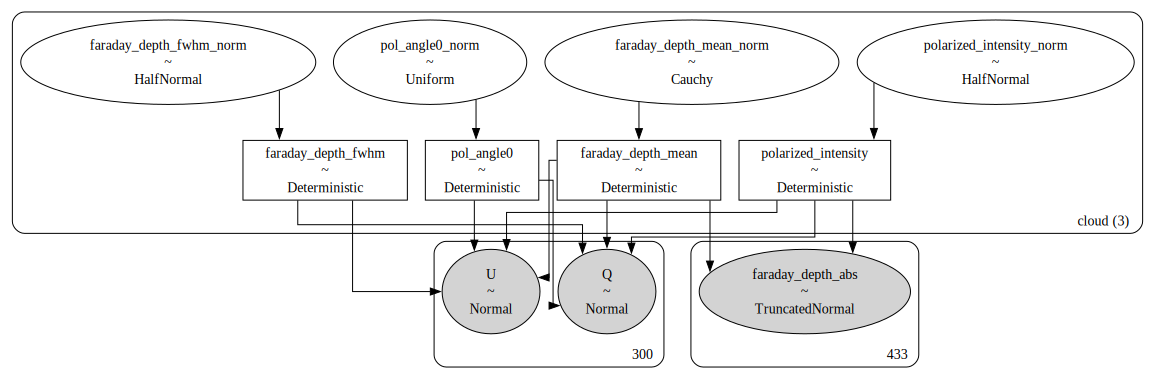

In [33]:
# Plot model graph
model.graph().render('faraday_model', format='png')
model.graph()

In [34]:
# model string representation
print(model.model.str_repr())

polarized_intensity_norm ~ HalfNormal(0, 1)
 faraday_depth_mean_norm ~ Cauchy(0, 1)
 faraday_depth_fwhm_norm ~ HalfNormal(0, 1)
         pol_angle0_norm ~ Uniform(-3.14, 3.14)
     polarized_intensity ~ Deterministic(f(polarized_intensity_norm))
      faraday_depth_mean ~ Deterministic(f(faraday_depth_mean_norm))
      faraday_depth_fwhm ~ Deterministic(f(faraday_depth_fwhm_norm))
              pol_angle0 ~ Deterministic(f(pol_angle0_norm))
       faraday_depth_abs ~ TruncatedNormal(f(polarized_intensity_norm, faraday_depth_mean_norm), <constant>, 0, inf)
                       Q ~ Normal(f(polarized_intensity_norm, pol_angle0_norm, faraday_depth_mean_norm, faraday_depth_fwhm_norm), <constant>)
                       U ~ Normal(f(polarized_intensity_norm, pol_angle0_norm, faraday_depth_mean_norm, faraday_depth_fwhm_norm), <constant>)


We check that our prior distributions are reasonable by drawing prior predictive checks. Each colored line is a simulated "observation" with parameters drawn from the prior distributions. You should check that these simulated observations at least somewhat overlap your actual observation (black line).

Sampling: [Q, U, faraday_depth_abs, faraday_depth_fwhm_norm, faraday_depth_mean_norm, pol_angle0_norm, polarized_intensity_norm]


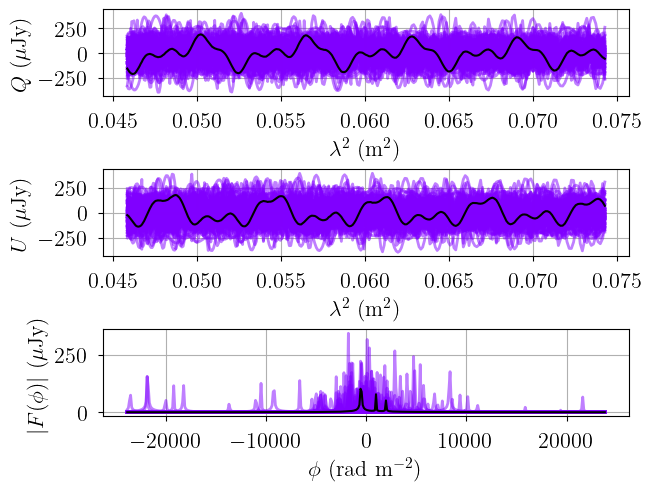

In [35]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

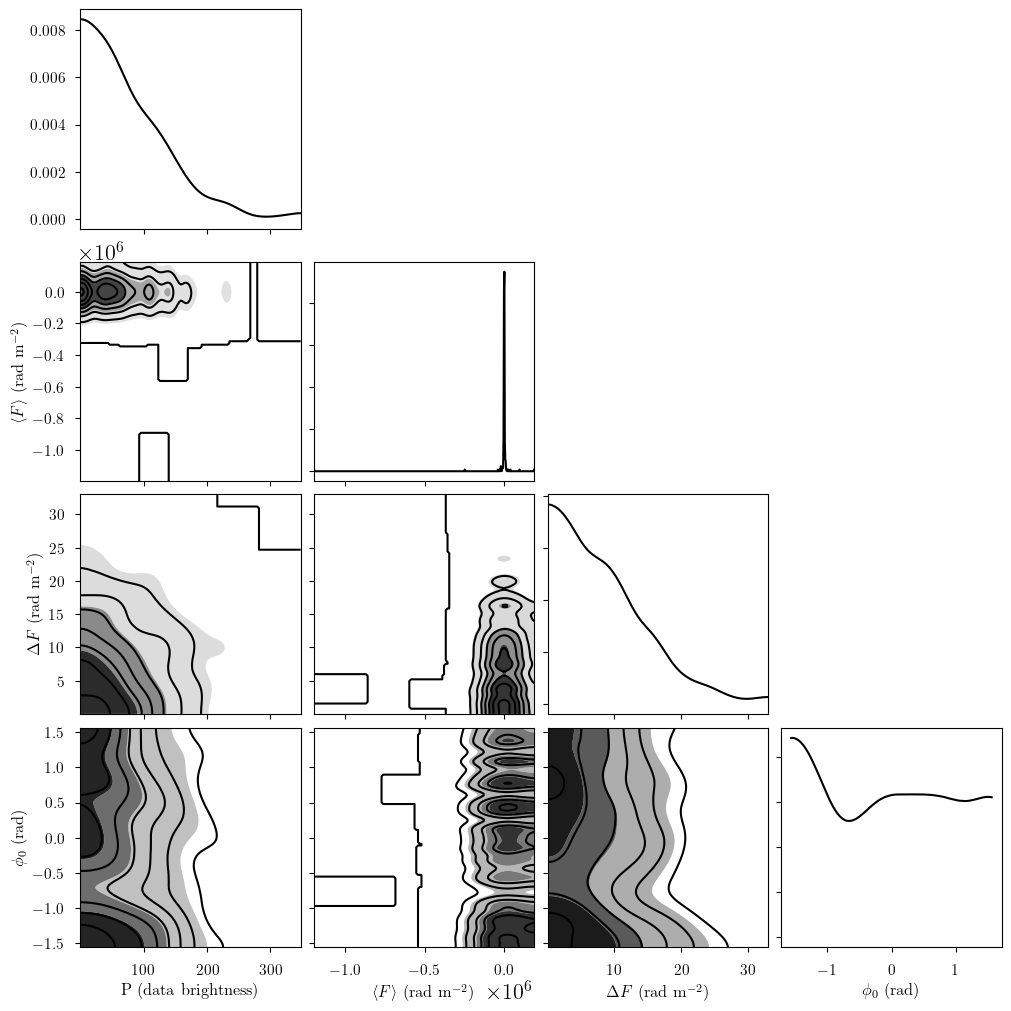

In [36]:
from bayes_spec.plots import plot_pair

_ = plot_pair(
    prior.prior, # samples
    model.cloud_deterministics,
    labeller=model.labeller, # label manager
)

## Variational Inference

We can approximate the posterior distribution using variational inference.

In [37]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.01, # VI absolute convergence threshold
    learning_rate = 0.01, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 68600
Interrupted at 68,599 [68%]: Average Loss = 1.3909e+06


Output()

Runtime: 0.57 minutes


In [38]:
# ignore transition and state dependent parameters
pm.summary(model.trace.posterior)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
faraday_depth_fwhm[0],6.457,0.050,6.370,6.547,0.002,0.001,982.0,1023.0,NaN
faraday_depth_fwhm[1],20.435,0.016,20.406,20.466,0.001,0.000,954.0,671.0,NaN
faraday_depth_fwhm[2],4.294,0.095,4.136,4.487,0.003,0.002,862.0,873.0,NaN
faraday_depth_fwhm_norm[0],0.646,0.005,0.637,0.655,0.000,0.000,982.0,1023.0,NaN
faraday_depth_fwhm_norm[1],2.044,0.002,2.041,2.047,0.000,0.000,954.0,671.0,NaN
faraday_depth_fwhm_norm[2],0.429,0.009,0.414,0.449,0.000,0.000,862.0,873.0,NaN
faraday_depth_mean[0],999.734,0.005,999.726,999.743,0.000,0.000,735.0,734.0,NaN
faraday_depth_mean[1],-499.862,0.012,-499.887,-499.841,0.000,0.000,881.0,983.0,NaN
faraday_depth_mean[2],2000.064,0.011,2000.044,2000.084,0.000,0.000,1073.0,978.0,NaN
faraday_depth_mean_norm[0],1.000,0.000,1.000,1.000,0.000,0.000,735.0,734.0,NaN


Sampling: [Q, U, faraday_depth_abs]


Output()

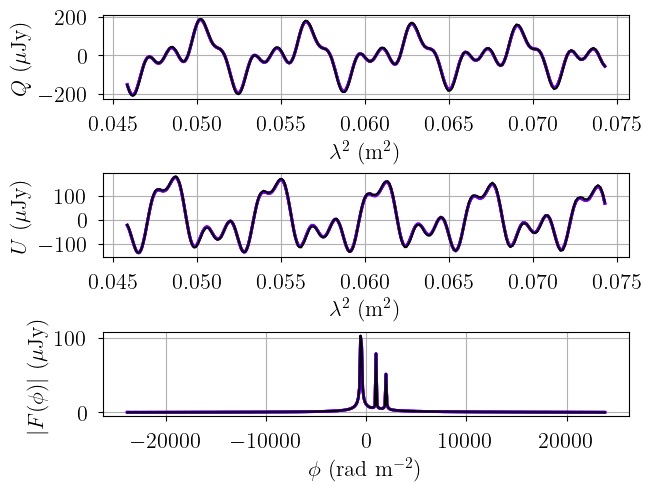

In [39]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## Posterior Sampling: MCMC

We can sample from the posterior distribution using MCMC.

In [40]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 6, # number of independent chains
    cores = 6, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.01, "learning_rate": 0.01}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 68600
Interrupted at 68,599 [68%]: Average Loss = 1.3909e+06
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [polarized_intensity_norm, faraday_depth_mean_norm, faraday_depth_fwhm_norm, pol_angle0_norm]


Output()

Sampling 6 chains for 1_000 tune and 1_000 draw iterations (6_000 + 6_000 draws total) took 56 seconds.


Adding log-likelihood to trace


Output()

Runtime: 1.75 minutes


In [41]:
model.solve(kl_div_threshold=0.1)

GMM converged to unique solution


In [42]:
print("solutions:", model.solutions)

# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state"]))
]
pm.summary(model.trace.posterior, var_names=var_names + model.hyper_deterministics + model.baseline_freeRVs)

solutions: [0]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
polarized_intensity[0],74.972,0.056,74.869,75.077,0.001,0.001,4901.0,4300.0,1.0
polarized_intensity[1],150.030,0.058,149.920,150.134,0.001,0.001,5168.0,4749.0,1.0
polarized_intensity[2],50.075,0.048,49.986,50.163,0.001,0.000,5572.0,4197.0,1.0
faraday_depth_mean[0],999.984,0.035,999.918,1000.050,0.001,0.001,2422.0,3416.0,1.0
faraday_depth_mean[1],-499.958,0.021,-499.995,-499.919,0.000,0.000,4687.0,3950.0,1.0
faraday_depth_mean[2],2000.009,0.050,1999.917,2000.105,0.001,0.001,3681.0,3756.0,1.0
faraday_depth_fwhm[0],5.058,0.080,4.908,5.210,0.001,0.001,4709.0,4314.0,1.0
faraday_depth_fwhm[1],19.996,0.015,19.967,20.023,0.000,0.000,4904.0,3829.0,1.0
faraday_depth_fwhm[2],0.719,0.443,0.001,1.454,0.008,0.006,2666.0,2226.0,1.0
pol_angle0[0],-0.400,0.002,-0.404,-0.396,0.000,0.000,2402.0,3198.0,1.0


We generate posterior predictive checks as well as a trace plot of the individual chains. In the posterior predictive plot, we show each chain as a different color. Each line is one posterior sample.

Sampling: [Q, U, faraday_depth_abs]


Output()

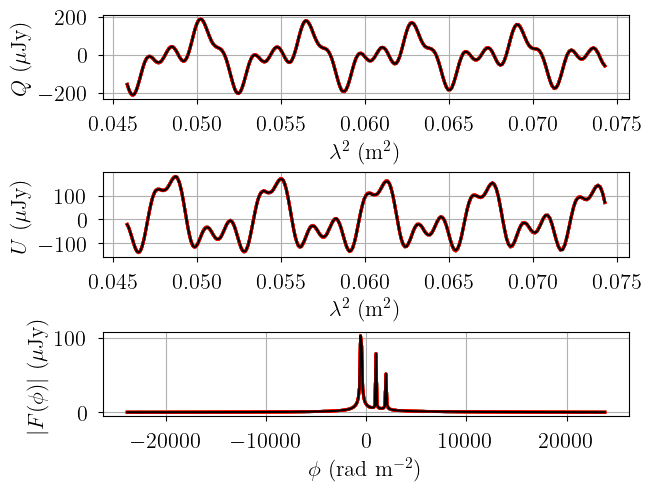

In [43]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

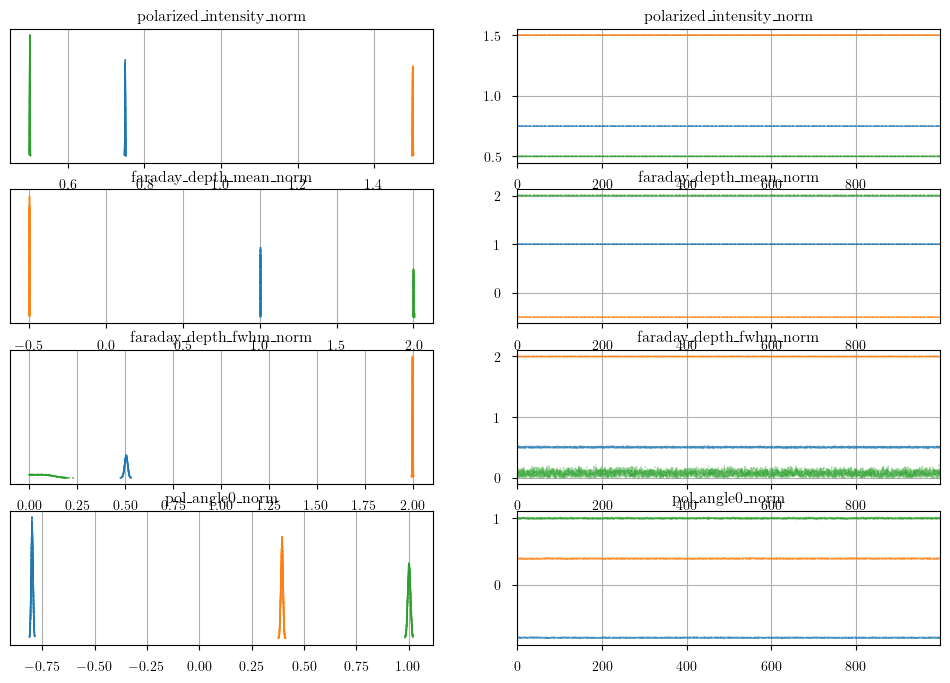

In [44]:
from bayes_spec.plots import plot_traces

_ = plot_traces(model.trace.solution_0, model.cloud_freeRVs)

We can inspect the posterior distribution pair plots. First, the normalized, free cloud parameters.

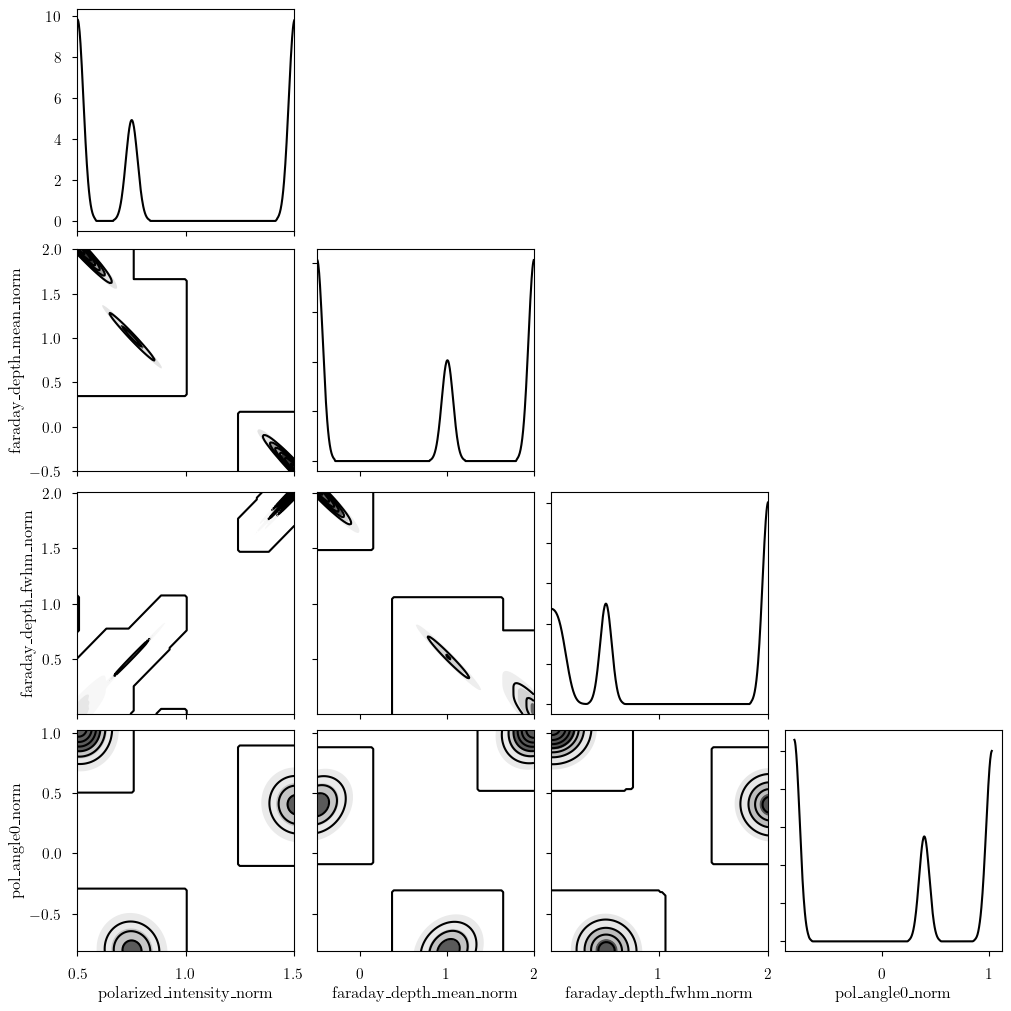

In [45]:
from bayes_spec.plots import plot_pair

_ = plot_pair(
    model.trace.solution_0, # samples
    model.cloud_freeRVs, # var_names to plot
    labeller=model.labeller, # label manager
)

Notice that there are three posterior modes. These correspond to the three clouds of the model. We can plot the posterior distributions of the deterministic quantities for a single cloud.

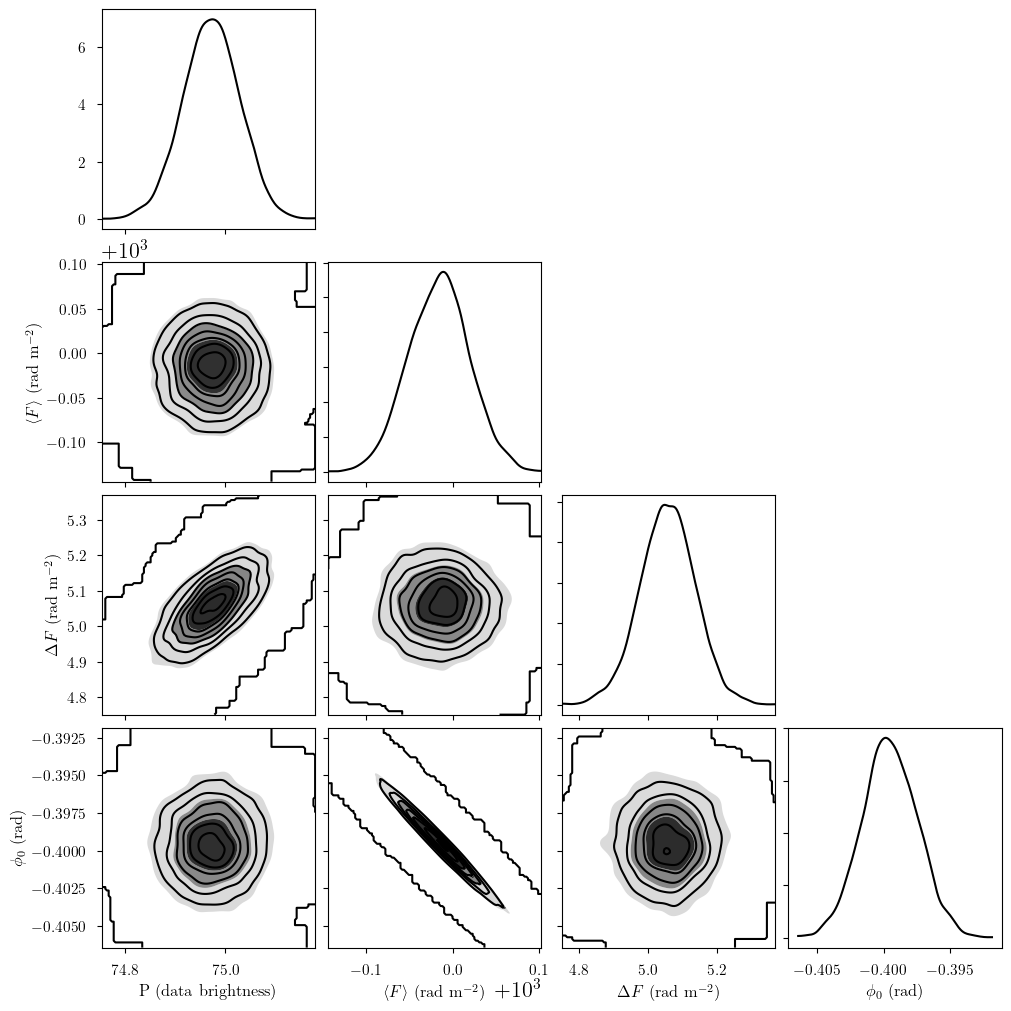

In [46]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    model.cloud_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

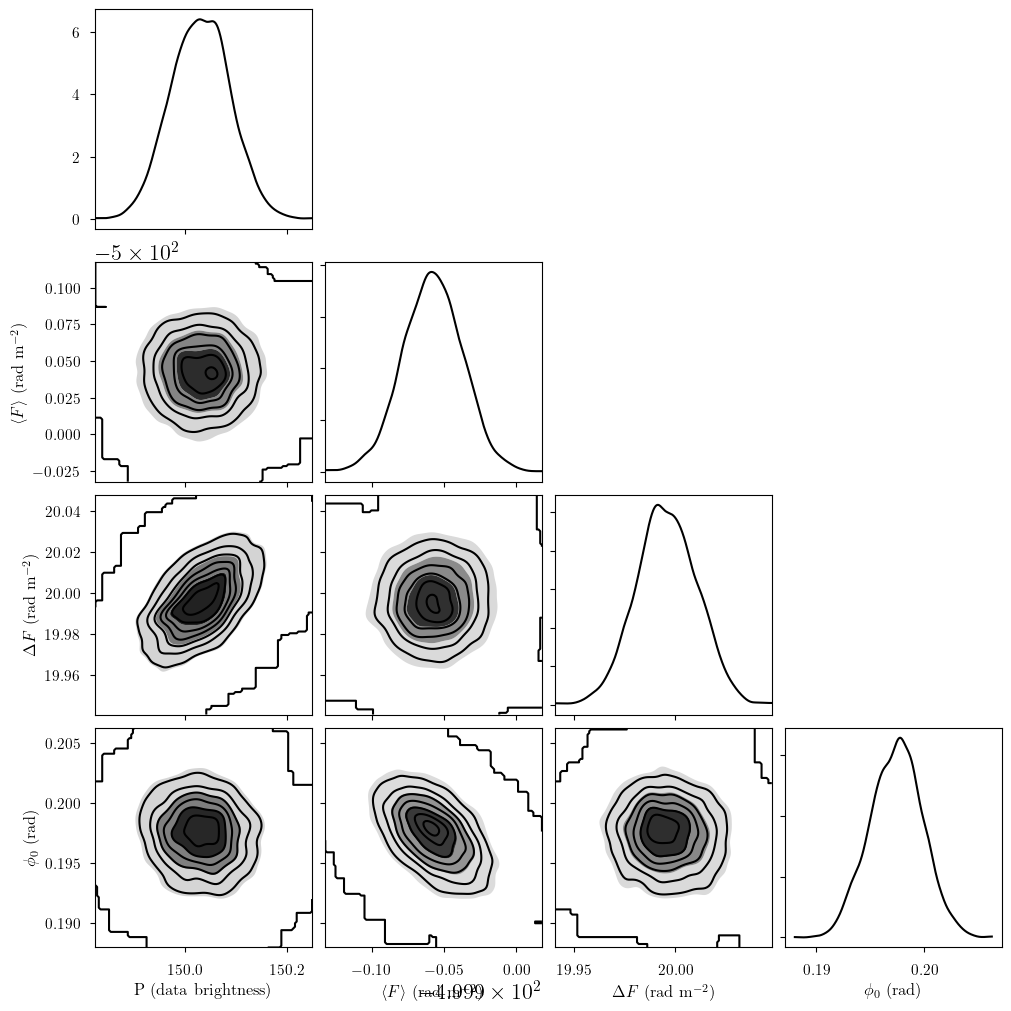

In [47]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=1), # samples
    model.cloud_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

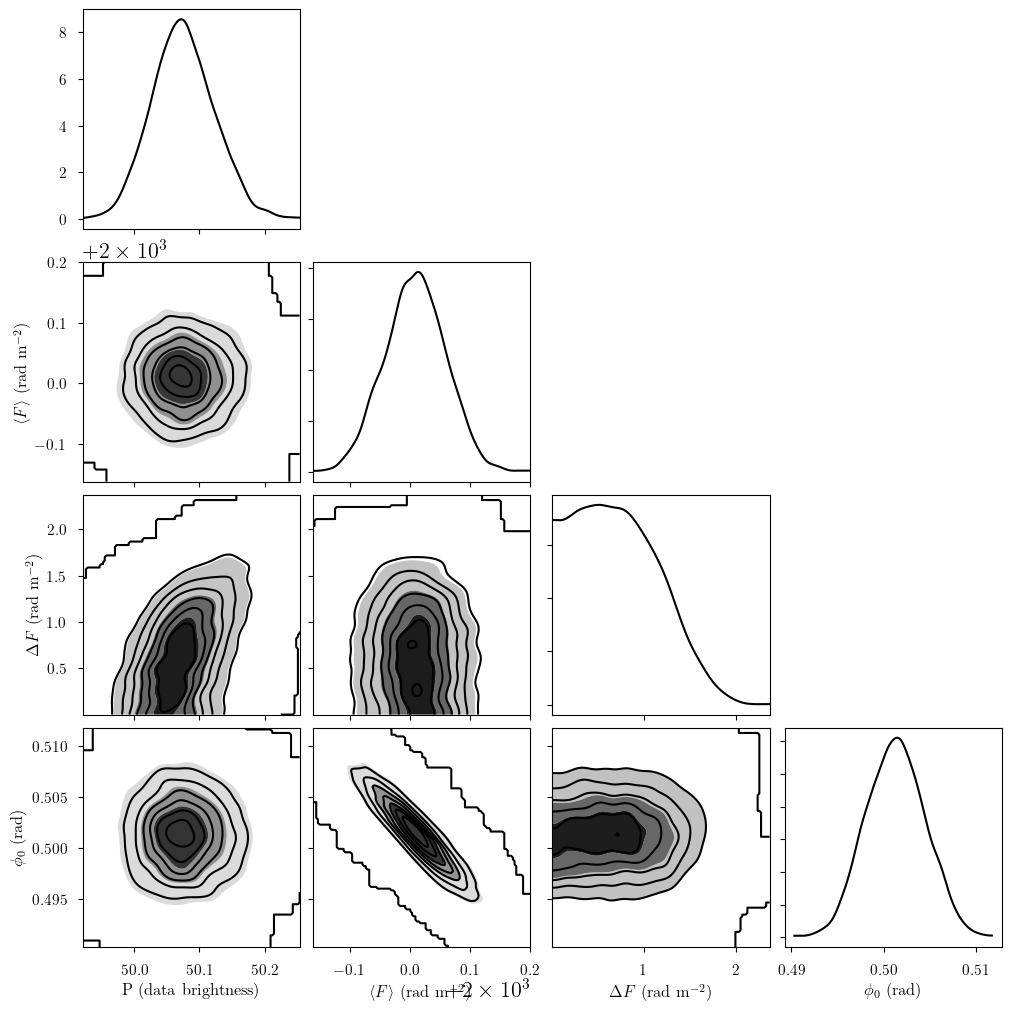

In [48]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=2), # samples
    model.cloud_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

Finally, we can get the posterior statistics, Bayesian Information Criterion (BIC), etc.

In [49]:
point_stats = az.summary(model.trace.solution_0, var_names=model.cloud_deterministics, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: 410.7708015691719


,mean,sd,hdi_16%,hdi_84%
polarized_intensity[0],74.972,0.056,74.917,75.027
polarized_intensity[1],150.030,0.058,149.972,150.087
polarized_intensity[2],50.075,0.048,50.026,50.120
faraday_depth_mean[0],999.984,0.035,999.947,1000.016
faraday_depth_mean[1],-499.958,0.021,-499.980,-499.939
faraday_depth_mean[2],2000.009,0.050,1999.960,2000.061
faraday_depth_fwhm[0],5.058,0.080,4.975,5.132
faraday_depth_fwhm[1],19.996,0.015,19.980,20.010
faraday_depth_fwhm[2],0.719,0.443,0.030,0.961
pol_angle0[0],-0.400,0.002,-0.402,-0.397
